<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls 'gdrive/MyDrive/_DL_school/219_Final_Image_Captioning/Image_Captioning/'

beheaded_inception3.py	handout.tar  image_captioning.ipynb


In [3]:
!tar -xf "/content/gdrive/MyDrive/_DL_school/219_Final_Image_Captioning/Image_Captioning/handout.tar"

In [4]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [5]:
print(img_codes[0].shape)
img_codes[0]

(2048,)


array([0.3659946 , 0.2016555 , 0.9245725 , ..., 0.00344942, 0.99817497,
       1.1091837 ], dtype=float32)

In [6]:
captions[0]

['people shopping in an open market for vegetables .',
 'an open market full of people and piles of vegetables .',
 'people are shopping at an open air produce market .',
 'large piles of carrots and potatoes at a crowded outdoor market .',
 'people shop for vegetables like carrots and potatoes at an open air market .']

In [7]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [8]:
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [9]:
from collections import Counter
word_counts = Counter()

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i][1:-1]:
            word_counts[word] += 1

vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

In [10]:
word_to_index = {w: i for i, w in enumerate(vocab)}

In [11]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Переводим лист из токенов в матрицу с отступами """
    max_len = max_len or max(map(len, sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
captions[0][0:1]

[['#START#',
  'people',
  'shopping',
  'in',
  'an',
  'open',
  'market',
  'for',
  'vegetables',
  '.',
  '#END#']]

In [13]:
as_matrix(captions[0])

array([[ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12,  2,  3,  3,  3,  3,  3],
       [ 1,  7,  8,  9, 13, 14,  4, 15, 16, 14, 11, 12,  2,  3,  3,  3],
       [ 1,  4, 17,  5, 18,  7,  8, 19, 20,  9, 12,  2,  3,  3,  3,  3],
       [ 1, 21, 16, 14, 22, 15, 23, 18, 24, 25, 26,  9, 12,  2,  3,  3],
       [ 1,  4, 27, 10, 11, 28, 22, 15, 23, 18,  7,  8, 19,  9, 12,  2]],
      dtype=int32)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [14]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [15]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size=2048, n_tokens=n_tokens, emb_size=128, lstm_units=256):
        super(self.__class__, self).__init__()

        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units).cuda()
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units).cuda()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx = pad_ix).cuda()
        self.lstm = nn.LSTM(batch_first = True, input_size = 64, hidden_size = lstm_units).cuda()
        self.logits = nn.Linear(lstm_units, n_tokens).cuda()
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM
        initial_cell = self.cnn_to_c0(image_vectors) # из картинки на выходе которой 2048 признаков переводим в скрытое состояние lstm вектора
        initial_hid = self.cnn_to_h0(image_vectors)
        captions_emb = self.emb(captions_ix) # из описания картинки в виде индексов переводим в эмбединги 64
        lstm_out, (cell_next, hid_next) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None])) # считаем lstm
        # None из torch.Size([5, 256]) делает torch.Size([1, 5, 256])

        logits = self.logits(lstm_out) # из выходного стоя lstm распределяем по словам из всех возможных токенов
        
        return logits

In [16]:
network = CaptionNet(n_tokens=n_tokens)

In [18]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    # contiguous здесь означает непрерывный в памяти. Таким образом, функция contiguous не влияет на ваш целевой тензор вообще, она просто гарантирует, что он хранится в непрерывном куске памяти.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    mask = captions_ix_next != pad_ix
    
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    #reshape
    next_reshaped = captions_ix_next.cuda().view(-1)
    logits_reshaped = logits_for_next.view(-1, logits_for_next.size()[-1])
    
    cross_entropy = nn.CrossEntropyLoss(reduction = 'none').cuda()
    loss = cross_entropy(logits_reshaped, next_reshaped).view(captions_ix_next.size()[0], captions_ix_next.size()[1]) * mask.float()
    loss = loss.mean(dim = -1).mean(dim = -1).view(-1) # loss по словам в предложении и по предложению т.к. для каждой картинки несколько описаний
    
    return loss

In [20]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3) # favourite one

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [21]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, test_size=0.1, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [22]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    batch_images = img_codes[random_image_ix] # берем случайную картинку
    captions_for_batch_images = captions[random_image_ix] # берем описания для картинки
    batch_captions = list(map(choice, captions_for_batch_images)) # выберем случайное описание
    batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).cuda(), torch.tensor(batch_captions_ix, dtype=torch.int64).cuda()

In [24]:
import tqdm.notebook as tq

batch_size = 128
n_epochs = 10
n_batches_per_epoch = 400
n_validation_batches = 10


for epoch in tq.tqdm(range(n_epochs), desc='n_epochs'):
    
    train_loss = 0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss_t.cpu().data.numpy()[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.cpu().data.numpy()[0]
    val_loss /= n_validation_batches
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch + 1, train_loss, val_loss))

print("Finished!")


Epoch: 1, train loss: 1.7603408600389958, val loss: 1.5851579666137696

Epoch: 10, train loss: 1.333663217127323, val loss: 1.311283540725708

Finished!


## Inseption и получение результатов


In [25]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Сгенерируем описание

In [26]:
caption_prefix=("#START#",)
caption_prefix=list(caption_prefix)
as_matrix([caption_prefix])

array([[1]], dtype=int32)

In [34]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=20):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        vectors_neck = vectors_neck.cuda()
        caption_prefix = list(caption_prefix)

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).cuda()
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [28]:
from matplotlib import pyplot as plt
# from scipy.misc import imresize
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
# img = imresize(img, (299, 299)).astype('float32') / 255.

--2021-01-30 17:47:39--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-01-30 17:47:39--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.001s  

2021-01-30 17:47:39 (53.9 MB/s) - ‘data/img.jpg’ sa

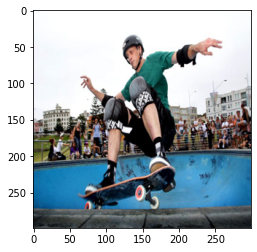

In [29]:
plt.imshow(img)

In [30]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard in the
a man riding a skateboard down a
a man riding a skateboard down a
a man riding a skateboard down a
a man riding a skateboard on top
a person riding a skateboard on a
a man riding a skateboard on a
a man riding a skateboard on a
a man riding a skateboard in the
a man riding a skateboard on a


--2021-01-30 17:48:00--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 146.20.65.28
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-01-30 17:48:00--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.006s  

2021-01-30 17:48:00 (15.9 MB/s) - ‘img.jpg’ saved [106870/106870]

(331, 645, 3)
(299, 299, 3)


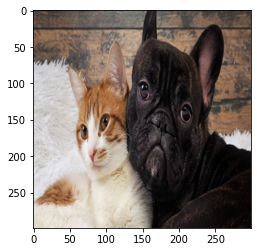

a cat is sitting on a bench
a cat that is laying on a
a cat is sitting on a bench
a black and white cat is sitting
a cat is standing on a wooden
a cat is sitting on the ground
a cat is sitting on the floor
a black and white cat is sitting
a black and white cat sitting on
a cat is sitting on a bench


In [31]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
print(img.shape)
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
print(img.shape)
# img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2021-01-30 17:51:45--  https://avatars.mds.yandex.net/get-zen_doc/3966998/pub_5fbbd8439e832457057cb94d_5fbbd8fe6ea65c24b39860b8/scale_1200
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.181, 87.250.247.184, 87.250.247.183, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160825 (157K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 157.06K   409KB/s    in 0.4s    

2021-01-30 17:51:47 (409 KB/s) - ‘img.jpg’ saved [160825/160825]

(675, 1200, 3)
(299, 299, 3)


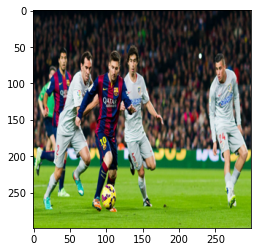

a group of people playing a game of frisbee .
a group of people standing on a field playing a game of frisbee .
a group of people playing soccer on a field .
a group of people standing on a field playing a game of soccer .
a group of people playing a game of frisbee .
a group of people playing a game of soccer .
a group of people playing soccer on a field .
a group of people playing frisbee in a field .
a group of people that are playing soccer .
a group of people playing frisbee in a field .


In [35]:
!wget https://avatars.mds.yandex.net/get-zen_doc/3966998/pub_5fbbd8439e832457057cb94d_5fbbd8fe6ea65c24b39860b8/scale_1200 -O img.jpg
img = plt.imread('img.jpg')
print(img.shape)
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
print(img.shape)
# img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))